In [1]:
import sys
sys.path.append("/sps/lsst/users/ebarroso/crow")
import crow
from crow.shear_profile import *

## Testing Shear implementation in shear_profile.py

In [2]:
import pyccl as ccl
hmf = ccl.halos.MassFuncTinker08(mass_def="200c")
cosmo = ccl.Cosmology(
    Omega_c=0.2607,      # Cold dark matter density
    Omega_b=0.04897,     # Baryon density
    h=0.6766,            # Hubble parameter
    sigma8=0.8102,       # Matter fluctuation amplitude
    n_s=0.9665,          # Spectral index
)
cl_delta_sigma = ClusterShearProfile(cosmo, hmf, 4.0, True)

cl_reduced_shear = ClusterShearProfile(cosmo, hmf, 4.0, False)

cl_reduced_shear_interp = ClusterShearProfile(cosmo, hmf, 4.0, False, True)

cl_reduced_shear_interp_mis = ClusterShearProfile(cosmo, hmf, 4.0, False, False)


### Test values of shear profile

In [3]:
import time

start = time.time()
ds_val = cl_delta_sigma.compute_shear_profile([13], [1.2], 3.0)
end = time.time()
print("Delta sigma:", ds_val, " | Time:", end - start, "s")

start = time.time()
cl_reduced_shear.set_beta_parameters(10)
gt_val = cl_reduced_shear.compute_shear_profile([13], [1.2], 3.0)
end = time.time()
print("Reduced shear exact:", gt_val, " | Time:", end - start, "s")

start = time.time()
cl_reduced_shear_interp.set_beta_parameters(10)
cl_reduced_shear_interp.set_beta_s_interp(1.1, 1.3)
gt_val = cl_reduced_shear_interp.compute_shear_profile([13], [1.2], 3.0)
end = time.time()
print("Reduced shear interpolated beta:", gt_val, " | Time:", end - start, "s")

start = time.time()
cl_reduced_shear_interp_mis.set_beta_parameters(10)
cl_reduced_shear_interp_mis.set_beta_s_interp(1.1, 1.3)
cl_reduced_shear_interp_mis.set_miscentering(0.2)
gt_val = cl_reduced_shear_interp_mis.compute_shear_profile([13], [1.2], 3.0)
end = time.time()
print("Reduced shear interpolated beta with miscentering:", gt_val, " | Time:", end - start, "s")


Delta sigma: [1.13451921e+12]  | Time: 0.002582550048828125 s
Reduced shear exact: [0.00027987]  | Time: 0.10103344917297363 s
Reduced shear interpolated beta: [0.00027987]  | Time: 0.04984331130981445 s
Reduced shear interpolated beta with miscentering: [0.00022393]  | Time: 0.17774176597595215 s


## Test implementation on the recipe

In [4]:
from crow.recipes.murata_binned_spec_z import MurataBinnedSpecZRecipe
from crow.mass_proxy import MurataBinned
from crow.kernel import SpectroscopicRedshift
#from firecrown.models.cluster import ClusterProperty
from crow.properties import ClusterProperty
import time

pivot_mass, pivot_redshift = 14.625862906, 0.6
mass_distribution = MurataBinned(pivot_mass, pivot_redshift)
redshift_distribution = SpectroscopicRedshift()

def run_recipe(label, cluster_theory, mass_proxy_interval1=(1.1, 1.2), mass_proxy_interval2=(0.2, 0.31), redshiftinterval1=(1, 2), redshiftinterval2=(0.86, 1.0)):
    print(f"\n{label} Starts here\n{'-'*50}")
    average_on = ClusterProperty.NONE
    average_on |= ClusterProperty.DELTASIGMA
    recipe = MurataBinnedSpecZRecipe(
        cluster_theory=cluster_theory,
        redshift_distribution=redshift_distribution,
        mass_distribution=mass_distribution,
    )

    t0 = time.time()
    val1 = recipe.evaluate_theory_prediction_shear_profile(mass_proxy_interval1, redshiftinterval1, 1.0, 440, average_on)
    t1 = time.time()
    print(f"Eval 1: {val1:.3e} | Time: {t1-t0:.4f} s")

    t2 = time.time()
    val2 = recipe.evaluate_theory_prediction_shear_profile(mass_proxy_interval2, redshiftinterval2, 4.0, 440, average_on)
    t3 = time.time()
    print(f"Eval 2: {val2:.3e} | Time: {t3-t2:.4f} s")

    counts = recipe.evaluate_theory_prediction_counts((0.2, 0.31), (0.86, 1.0), 440)
    print(f"Counts: {counts:.3e}")

# Run different scenarios
run_recipe("Delta Sigma", cl_delta_sigma)
run_recipe("Tangential Shear", cl_reduced_shear)
run_recipe("Tangential Shear with Interpolation", cl_reduced_shear_interp)



Delta Sigma Starts here
--------------------------------------------------
Eval 1: 8.249e+15 | Time: 0.9004 s
Eval 2: 1.309e+15 | Time: 0.3996 s
Counts: 2.658e+02

Tangential Shear Starts here
--------------------------------------------------
Eval 1: 2.134e+00 | Time: 12.8075 s
Eval 2: 4.438e-01 | Time: 20.8553 s
Counts: 2.658e+02

Tangential Shear with Interpolation Starts here
--------------------------------------------------
Eval 1: 2.134e+00 | Time: 0.6747 s
Eval 2: 4.438e-01 | Time: 0.7114 s
Counts: 2.658e+02


### Interpolation test

0.1 0.6


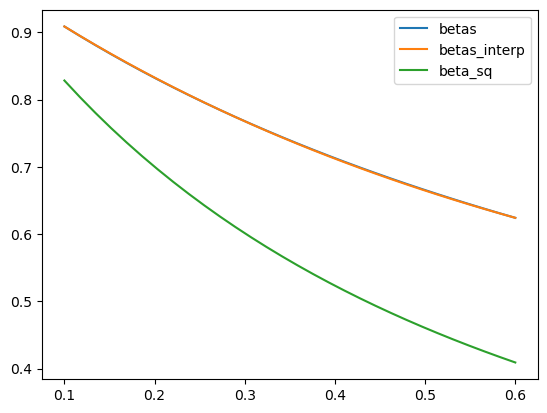

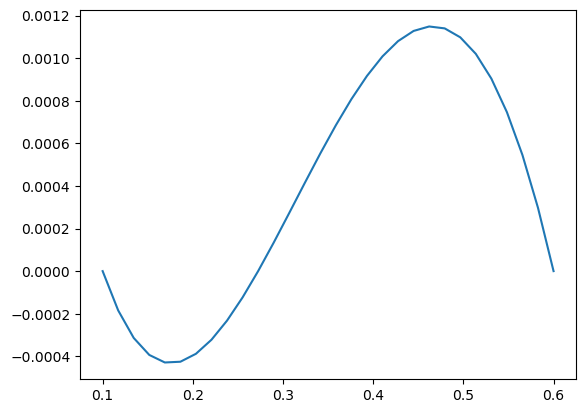

0.2111111111111111 0.7111111111111111


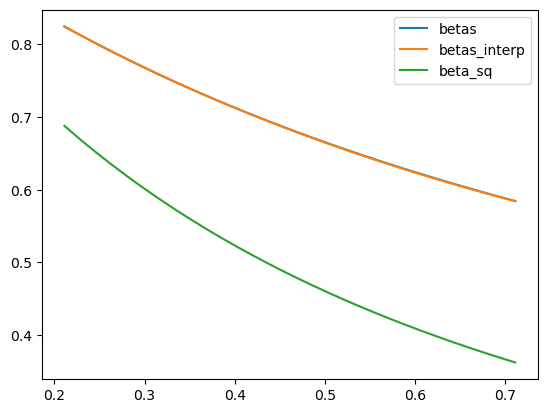

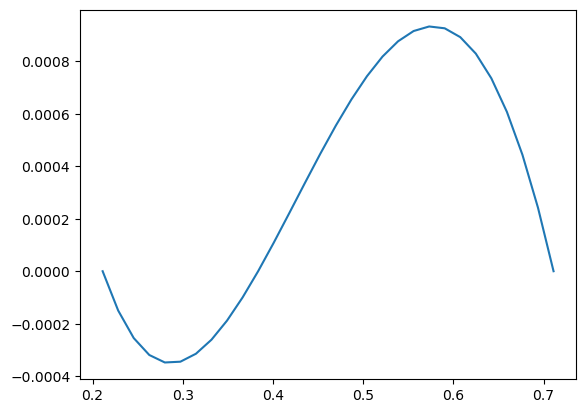

0.3222222222222222 0.8222222222222222


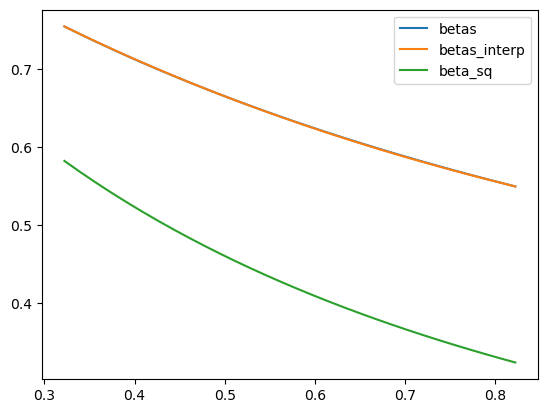

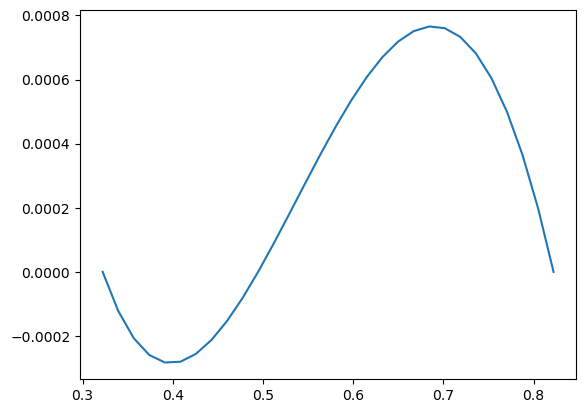

0.43333333333333335 0.9333333333333333


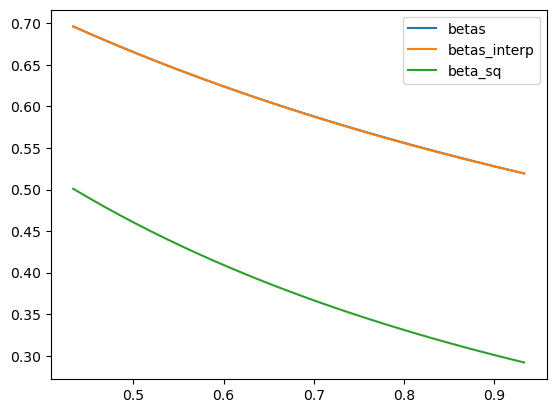

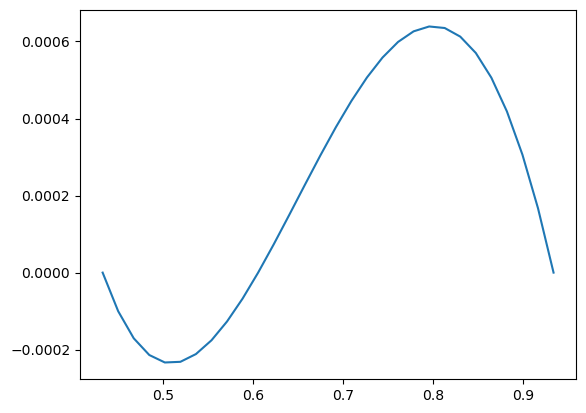

0.5444444444444444 1.0444444444444443


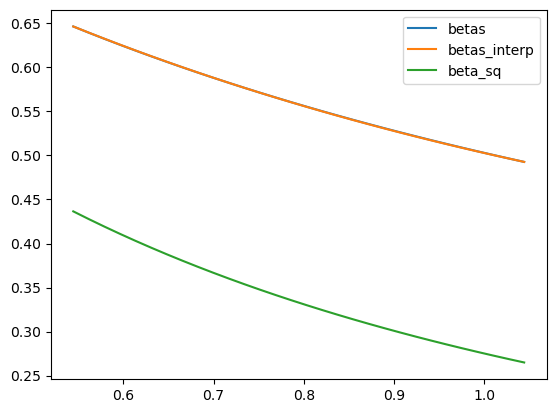

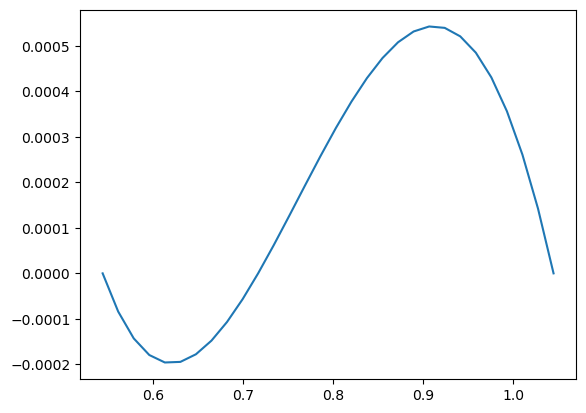

0.6555555555555556 1.1555555555555554


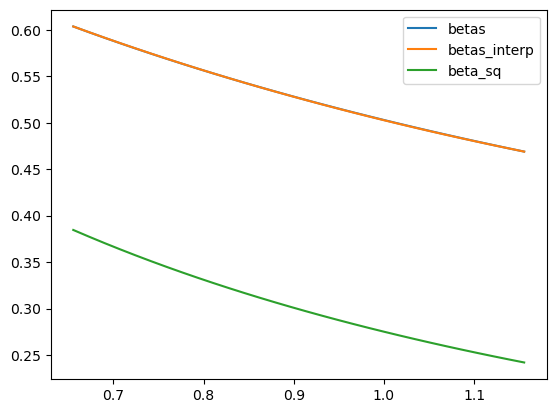

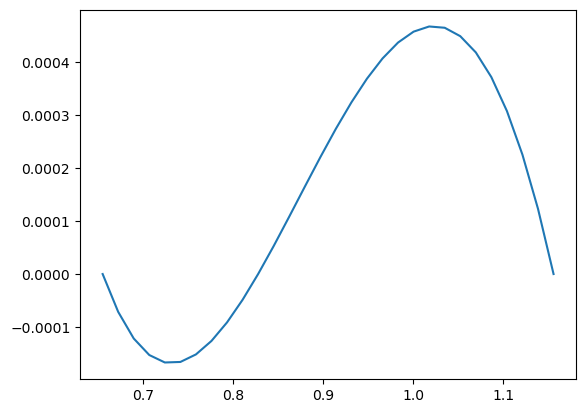

0.7666666666666666 1.2666666666666666


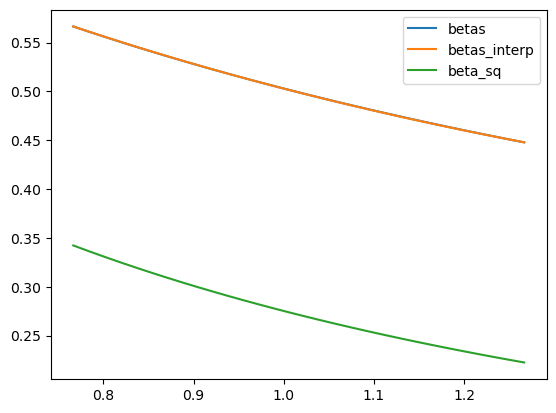

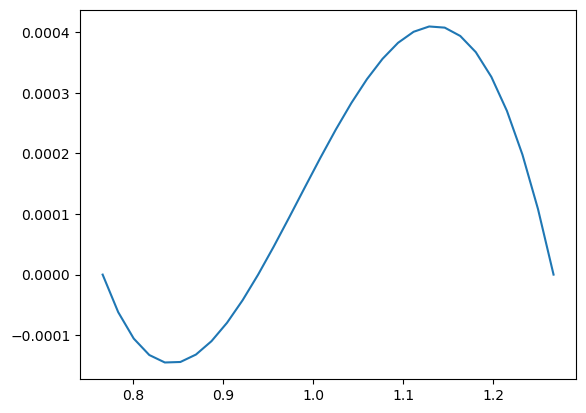

0.8777777777777777 1.3777777777777778


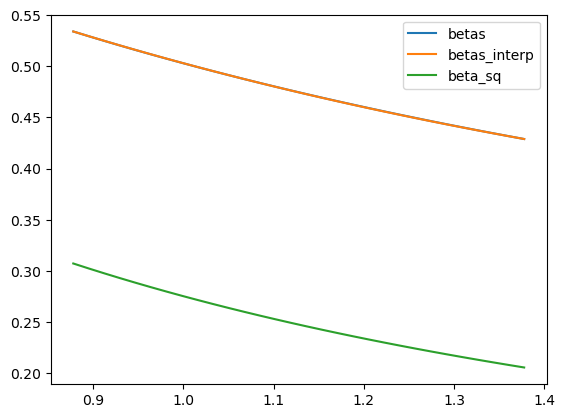

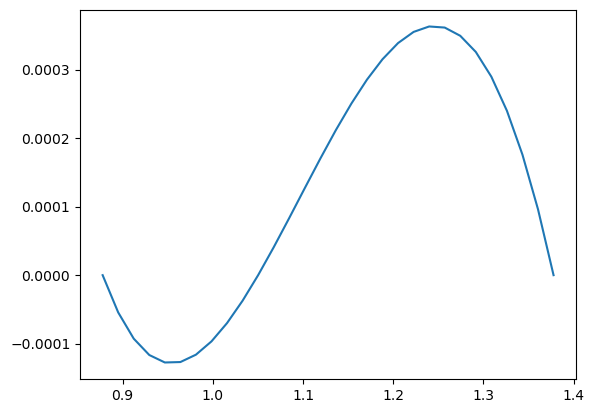

0.9888888888888888 1.488888888888889


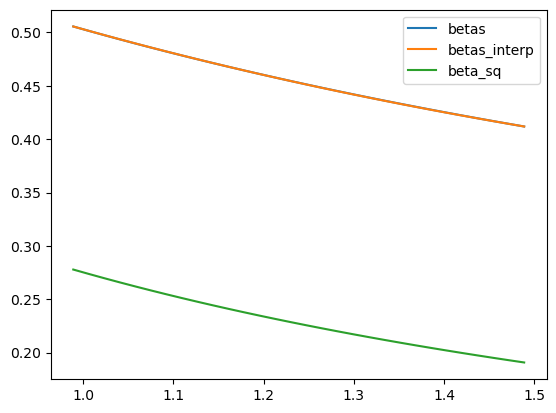

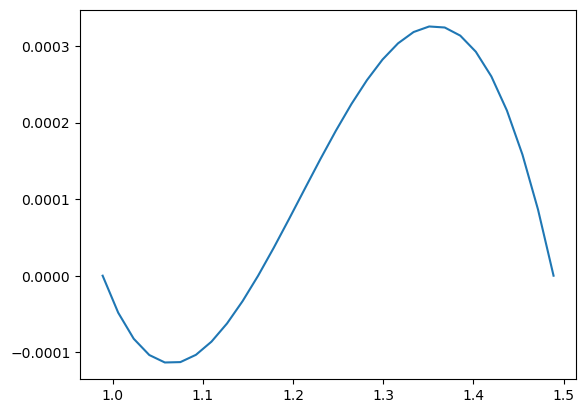

1.1 1.6


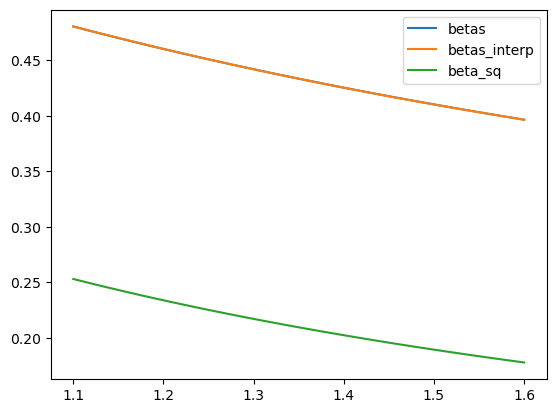

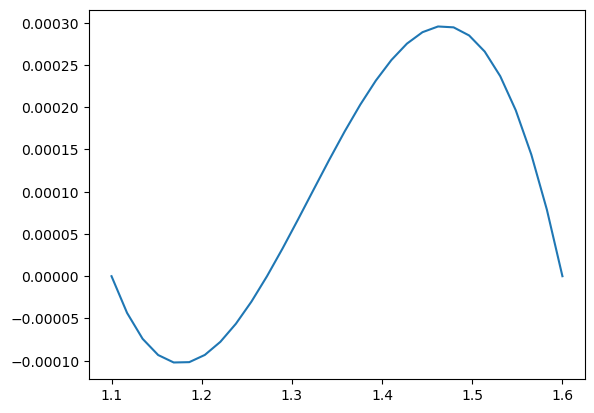

In [5]:
import clmm
import numpy as np
import matplotlib.pyplot as plt
clmm_cosmo = clmm.Cosmology()
clmm_cosmo._init_from_cosmo(cosmo)
from scipy.interpolate import interp1d
bins = [(bin1, bin1 + 0.5) for bin1 in np.linspace(0.1, 1.1, 10)]
z_inf = 10
zmax = 5.0
for bin1,bin2 in bins:
    print(bin1,bin2)
    z_cls = np.linspace(bin1, bin2, 30)
    beta_list = []
    beta_sq_list = []
    for z_cl in z_cls:
        beta_smean = clmm.utils.compute_beta_s_mean_from_distribution(z_cl, z_inf, clmm_cosmo, zmax=zmax, delta_z_cut=0.3, zmin=None, z_distrib_func=None)
        beta_sqmean = clmm.utils.compute_beta_s_square_mean_from_distribution(z_cl, z_inf, clmm_cosmo, zmax=zmax, delta_z_cut=0.3, zmin=None, z_distrib_func=None)
        beta_list.append(beta_smean)
        beta_sq_list.append(beta_sqmean)
    log_beta_interp = interp1d(
    [z_cls[0], z_cls[10], z_cls[-1]],
    np.log([beta_list[0], beta_list[10], beta_list[-1]]),
    kind='quadratic',
    fill_value='extrapolate'# or 'cubic', 'quadratic' for smoother
)
    interpolated = log_beta_interp(z_cls)   #np.interp(z_cls,[z_cls[0], z_cls[-1]],[np.log(beta_list[0]), np.log(beta_list[-1])])
    # beta_sqmean[-1] beta_sqmean[0]
    plt.plot(z_cls, beta_list, label='betas')
    plt.plot(z_cls, np.exp(interpolated), label='betas_interp')
    plt.plot(z_cls, beta_sq_list, label = 'beta_sq')
    plt.legend()
    plt.show()
    plt.plot(z_cls, 1 - np.exp(interpolated)/np.array(beta_list))
    plt.show()